Github repo: https://github.com/wenjie-mo/ECE188DeepLearning

<a href="https://colab.research.google.com/github/shreyasrajesh0308/ECE188DeepLearning/blob/main/Adv_example_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tabulate import tabulate
import re

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
Panda_path= 'drive/My Drive/Class/ECE 188/ECE 188 Project 2/Panda/panda_bear.jpeg'

Mounted at /content/drive


In [ ]:
image_raw = tf.io.read_file(Panda_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

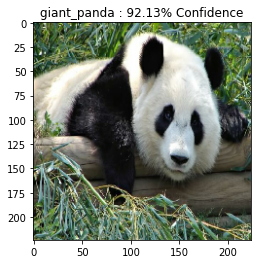

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

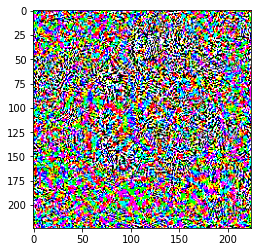

In [ ]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

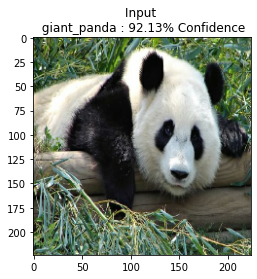

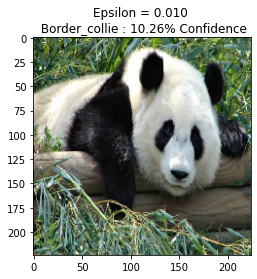

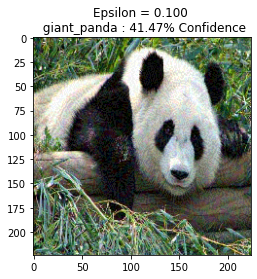

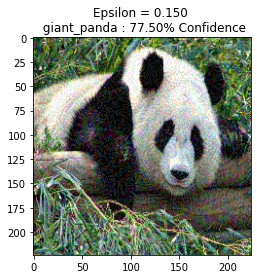

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [ ]:
GOOGLE_DRIVE_PATH = 'drive/My Drive/Class/ECE 188/ECE 188 Project 2/Images'
print(os.listdir(GOOGLE_DRIVE_PATH))

image_list = [tf.image.decode_image(tf.io.read_file(os.path.join(GOOGLE_DRIVE_PATH, pic))) for pic in os.listdir(GOOGLE_DRIVE_PATH)]
name_list = [pic for pic in os.listdir(GOOGLE_DRIVE_PATH)]

name_to_index = {"n04266014_space_shuttle.jpg": 812, 
                 "n02012849_crane.jpg": 134, 
                 "n02108089_boxer.jpg": 242, 
                 "n02137549_mongoose.jpg": 298, 
                 "n02823428_beer_bottle.jpg": 440,
                 "n03290653_entertainment_center.jpg": 548,
                 "n03095699_container_ship.jpg": 510,
                 "n03691459_loudspeaker.jpg": 632,
                 "n03538406_horse_cart.jpg": 603,
                 "n02906734_broom.jpg": 462 
                 }

['n03691459_loudspeaker.jpg', 'n03095699_container_ship.jpg', 'n02823428_beer_bottle.jpg', 'n02137549_mongoose.jpg', 'n02108089_boxer.jpg', 'n02012849_crane.jpg', 'n02906734_broom.jpg', 'n03538406_horse_cart.jpg', 'n04266014_space_shuttle.jpg', 'n03290653_entertainment_center.jpg']


In [ ]:
def my_display_images(image, description, label, confidence):
  plt.figure(figsize=(2, 2))
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

def get_label(image_name, image, index):
  iamge_class = re.findall(r'_(.*?)\.', image_name)[0]
  table_flag = True
  image_probs = pretrained_model.predict(image)

  _, axs = plt.subplots(1, 3, figsize=(8, 8))
  axs[0].imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
  _, image_class, class_confidence = get_imagenet_label(image_probs)
  axs[0].set_title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))

  # Get the input label of the image.
  label = tf.one_hot(name_to_index[image_name], image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern(image, label)
  axs[1].imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

  epsilons = [i*0.001 for i in range(1000)]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]

  for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    if str(label) != iamge_class and table_flag:
      table_flag = False
      my_table[index].append(eps)
      axs[2].imshow(image[0]*0.5+0.5)
      axs[2].set_title('{} \n {} : {:.2f}% Confidence'.format(descriptions[i], label, confidence*100))
      plt.show()
      break
    
    if not table_flag:
      break
  if table_flag:
    my_table[index].append("> 0.9")


In [ ]:
# Create table for eps results
head = ["Index", "Name"]
my_table = []
def init_table():
  for i in name_list:
    iamge_class = re.findall(r'_(.*?)\.', i)[0]
    my_table.append([name_to_index[i], iamge_class])
init_table()

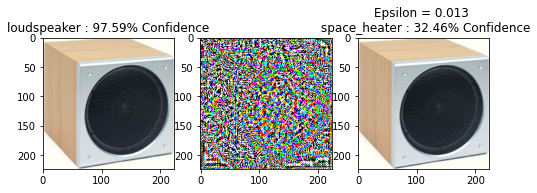

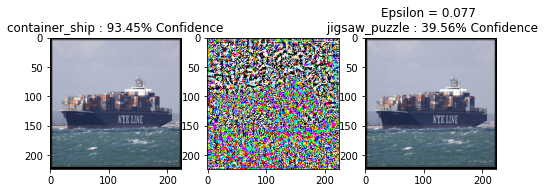

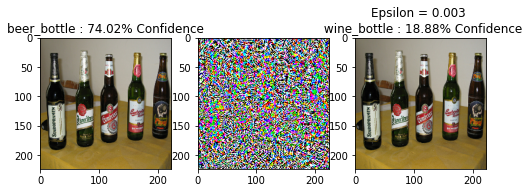

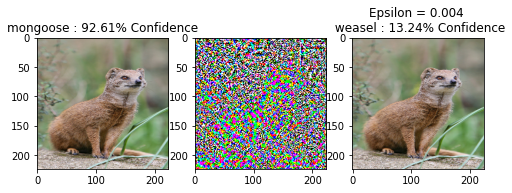

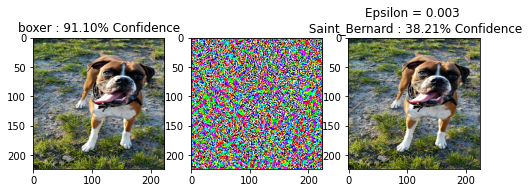

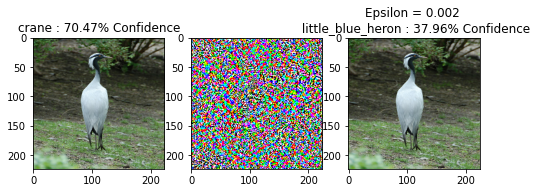

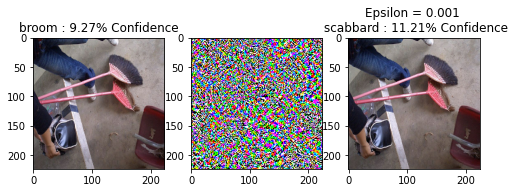

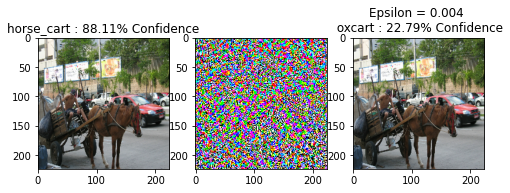

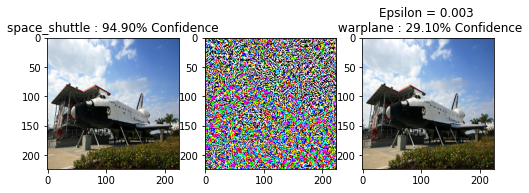

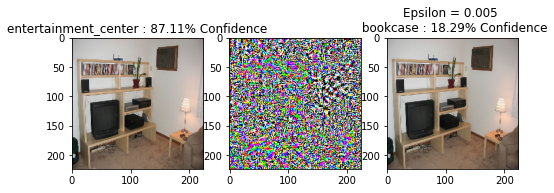

In [ ]:
head.append("MobileNetV2")
for i, v in enumerate(image_list):
  get_label(name_list[i], preprocess(v), i)


In [ ]:
print(tabulate(my_table, headers=head, tablefmt="grid"))

+---------+----------------------+---------------+
|   Index | Name                 |   MobileNetV2 |
+=========+======================+===============+
|     632 | loudspeaker          |         0.013 |
+---------+----------------------+---------------+
|     510 | container_ship       |         0.077 |
+---------+----------------------+---------------+
|     440 | beer_bottle          |         0.003 |
+---------+----------------------+---------------+
|     298 | mongoose             |         0.004 |
+---------+----------------------+---------------+
|     242 | boxer                |         0.003 |
+---------+----------------------+---------------+
|     134 | crane                |         0.002 |
+---------+----------------------+---------------+
|     462 | broom                |         0.001 |
+---------+----------------------+---------------+
|     603 | horse_cart           |         0.004 |
+---------+----------------------+---------------+
|     812 | space_shuttle      

# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [ ]:
def my_preprocess(image, image_method, resize):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, resize)
  image = image_method(image)
  image = image[None, ...]
  return image

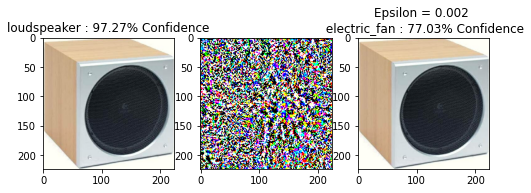

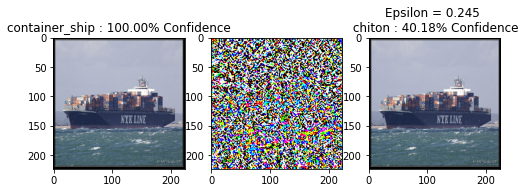

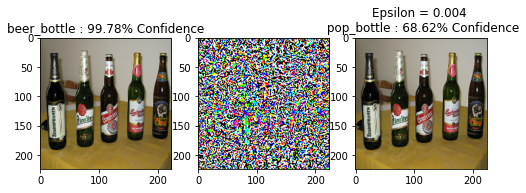

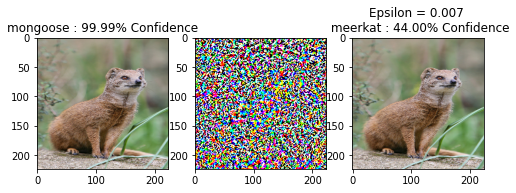

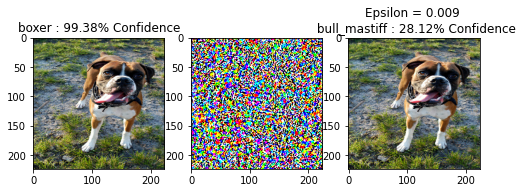

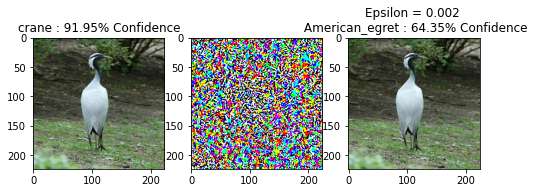

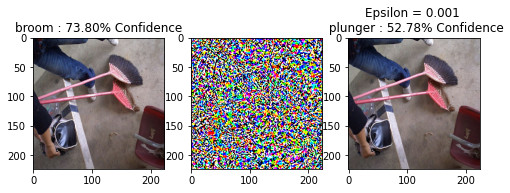

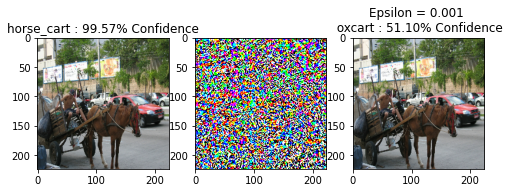

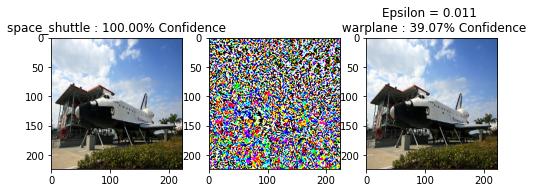

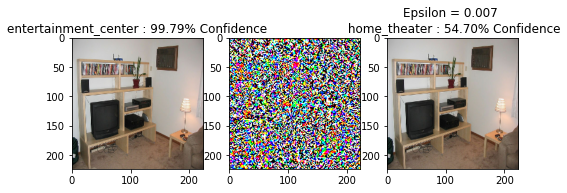

In [ ]:
head.append('ResNet152V2')
pretrained_model = tf.keras.applications.ResNet152V2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
for i, v in enumerate(image_list):
  get_label(name_list[i], my_preprocess(v, preprocess_input, (224,224)), i)


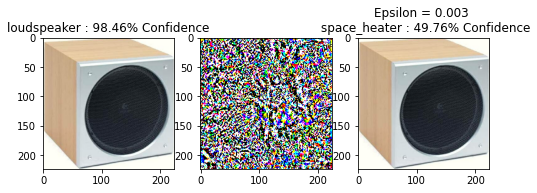

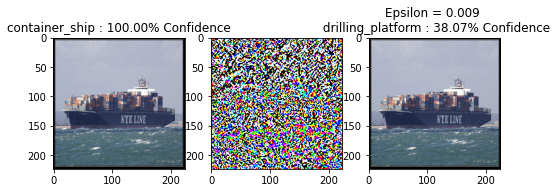

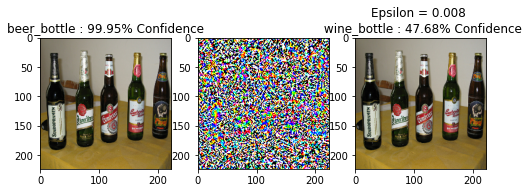

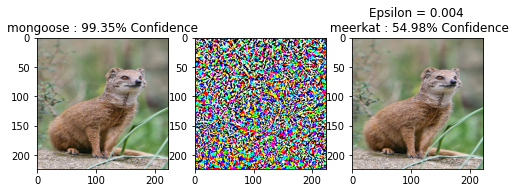

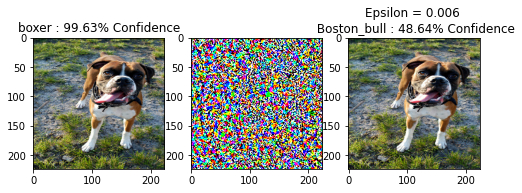

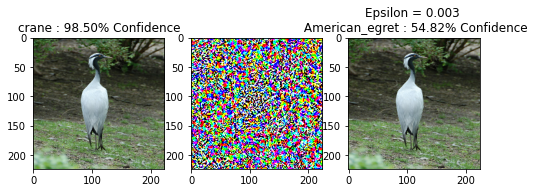

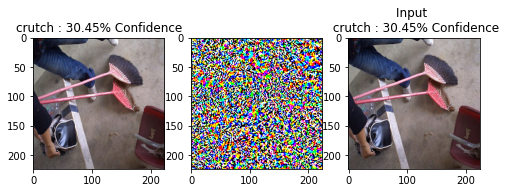

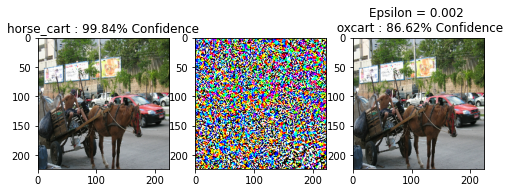

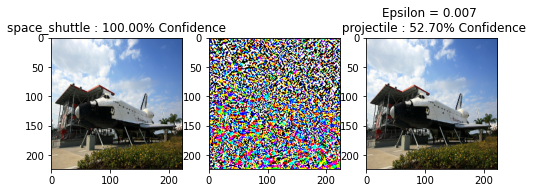

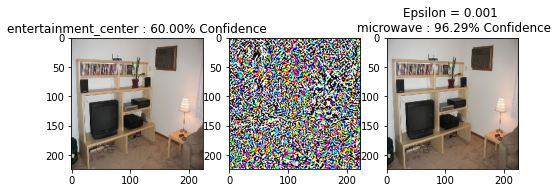

In [ ]:
head.append('ResNet50V2')
pretrained_model = tf.keras.applications.ResNet50V2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
for i, v in enumerate(image_list):
  get_label(name_list[i], my_preprocess(v, preprocess_input, (224,224)), i)

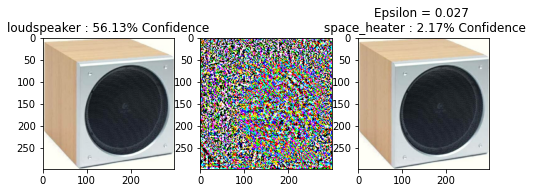

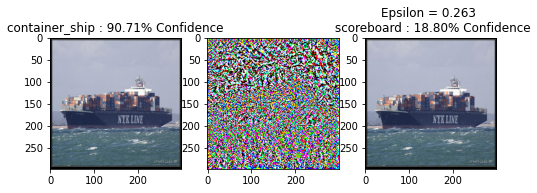

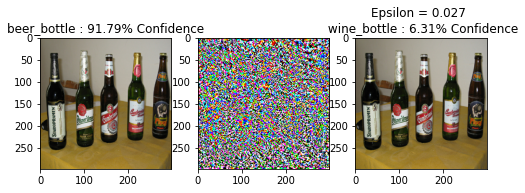

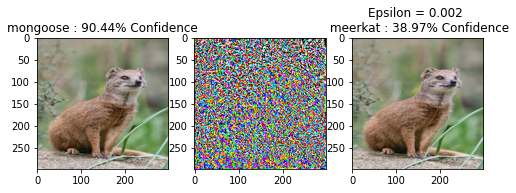

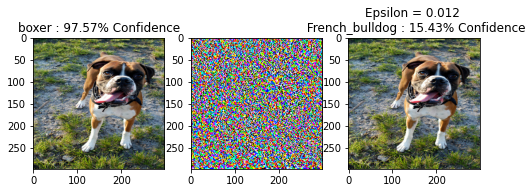

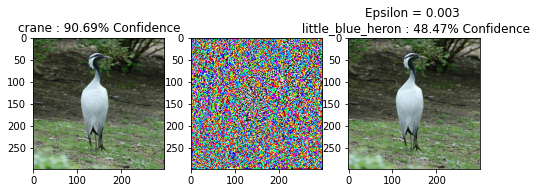

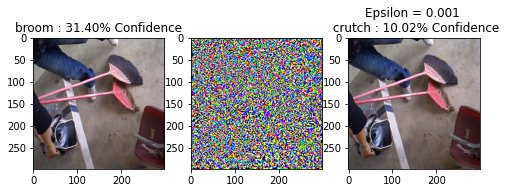

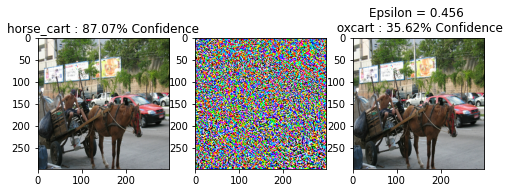

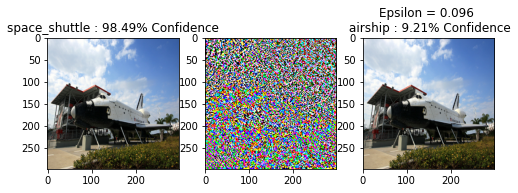

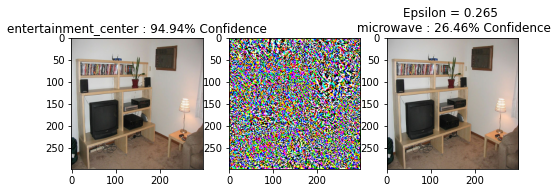

In [ ]:
head.append('Xception')
pretrained_model = tf.keras.applications.Xception(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.xception.decode_predictions
preprocess_input = tf.keras.applications.xception.preprocess_input
for i, v in enumerate(image_list):
  get_label(name_list[i], my_preprocess(v, preprocess_input, (299,299)), i)

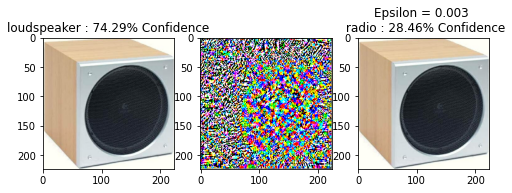

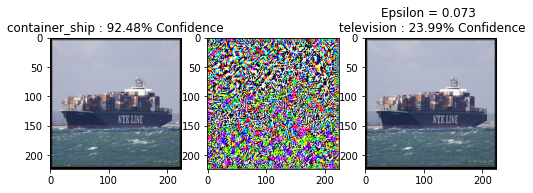

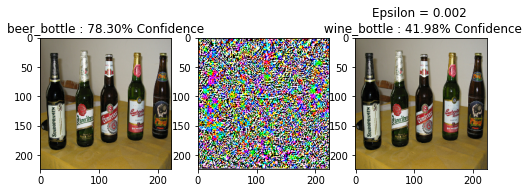

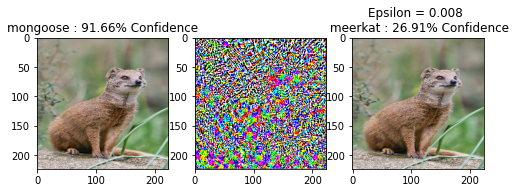

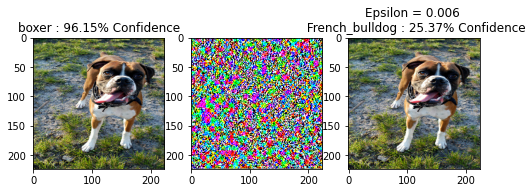

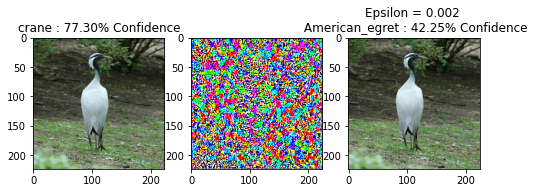

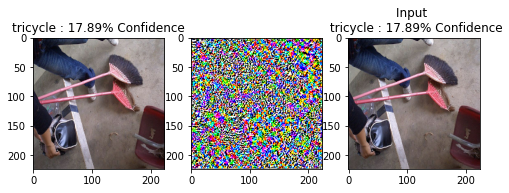

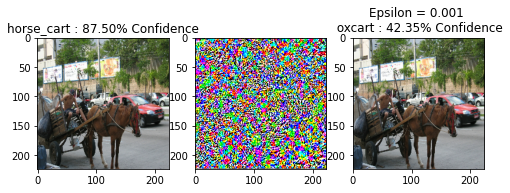

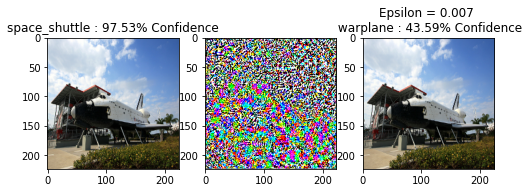

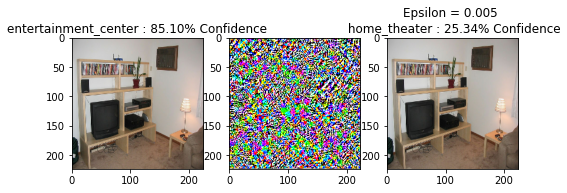

In [ ]:
head.append('NASNetMobile')
pretrained_model = tf.keras.applications.NASNetMobile(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.nasnet.decode_predictions
preprocess_input = tf.keras.applications.nasnet.preprocess_input
for i, v in enumerate(image_list):
  get_label(name_list[i], my_preprocess(v, preprocess_input, (224,224)), i)

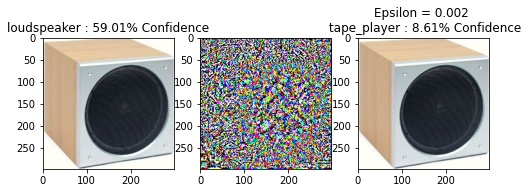

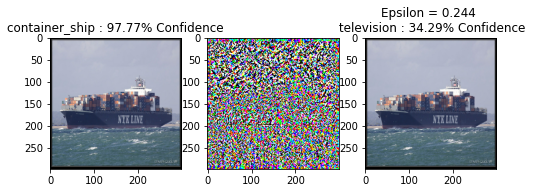

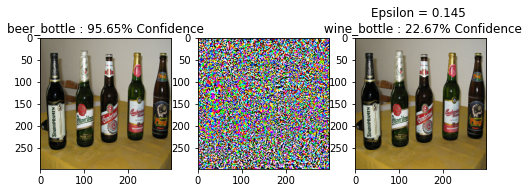

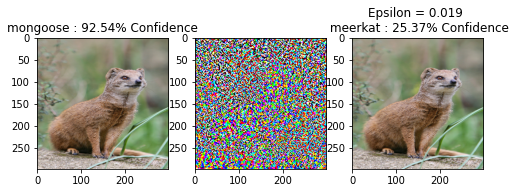

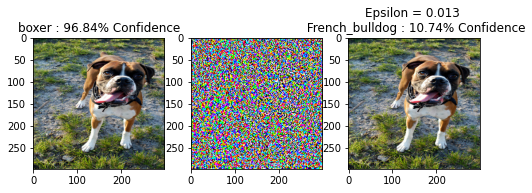

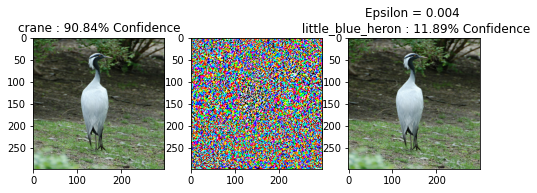

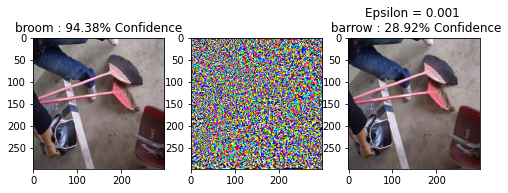

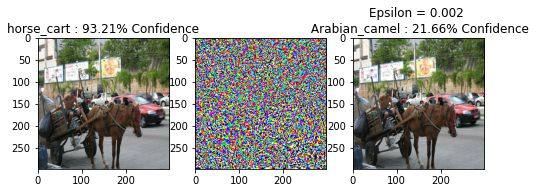

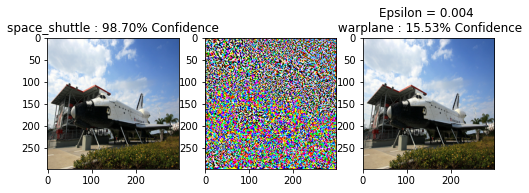

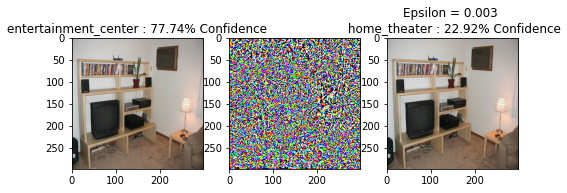

In [ ]:
head.append('InceptionV3')
pretrained_model = tf.keras.applications.InceptionV3(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.inception_v3.decode_predictions
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
for i, v in enumerate(image_list):
  get_label(name_list[i], my_preprocess(v, preprocess_input, (299,299)), i)

In [ ]:
# Summary
print(tabulate(my_table, headers=head, tablefmt="grid"))

+---------+----------------------+---------------+---------------+--------------+------------+----------------+---------------+
|   Index | Name                 |   MobileNetV2 |   ResNet152V2 |   ResNet50V2 |   Xception |   NASNetMobile |   InceptionV3 |
+=========+======================+===============+===============+==============+============+================+===============+
|     632 | loudspeaker          |         0.013 |         0.002 |        0.003 |      0.027 |          0.003 |         0.002 |
+---------+----------------------+---------------+---------------+--------------+------------+----------------+---------------+
|     510 | container_ship       |         0.077 |         0.245 |        0.009 |      0.263 |          0.073 |         0.244 |
+---------+----------------------+---------------+---------------+--------------+------------+----------------+---------------+
|     440 | beer_bottle          |         0.003 |         0.004 |        0.008 |      0.027 |          

## Resistance to attack ranking
Xception, InceptionV3, ResNet152V2, MobileNetV2, NASNetMobile, ResNet50V2 

## Observation:
- Average episilon is very differnt across different class of images.
- For different [CNN network structures](https://keras.io/api/applications/), the amount of episilon (adversarial changes) needed can be vastly different. For example DenseNet169 needs a very large episilon applied for FGSM attack to change the prediction result, which means it is the most resistant to the FGSM attack. The depth of the network is not strongly correlated to the resistance to attack.



## Explanation
- Already complex images (mix with object, other objects, and backgrounds) can be hard to classify already, the noise makes it more vulunable under attack. However, for simpler images (such as container ship), the image itself is very clear under classifier so more resistant under attack.
- Due to the structure of each different network, the feature extractor might be atffected differently for a given adversarial example. Among the same structure, such as Resnet, a deeper network typically means more resistance to the FGSM attack as proved in the epsilon. For several artectures, they use skip connection to improve the robustness against adversial examples such as densenet and resnet, so the performance is generally good. For lighter and no skip connection networks such as MobileNetV2, they are more vulunable to the attack.

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 